# Классификация текстов с помощью модели BERT



Материалы основаны на [Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)

Рассмотрим задачу сентиментального анализа текстов (классификация текстов по оценке).
В качестве данных будем использовать отзывы на приложения в Google Play.
Данные содержат тексты отзывов и оценки, которые пользователи поставили приложениям (от 1 до 5).

Наша задача -- построить модель, которая сможет предсказать оценку пользователя на основе текста его отзыва.

Для решения этой задачи мы будем использовать модель BERT, основанную на архитектуре Transformer.

Мы научимся:
- Обрабатывать данные для модели BERT
- Дообучать модель BERT на нашем наборе данных
- Использовать обученную модель для оценки текстов

## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face

In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.6 MB/s eta 0:00:00


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.0.1+cu118
transformers: 4.34.0



Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 131MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 35.1MB/s]


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
df = pd.read_csv("reviews.csv")
print("Количество примеров: ", df.shape[0])

Количество примеров:  15746


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


Посмотрим на распределение классов в выборке

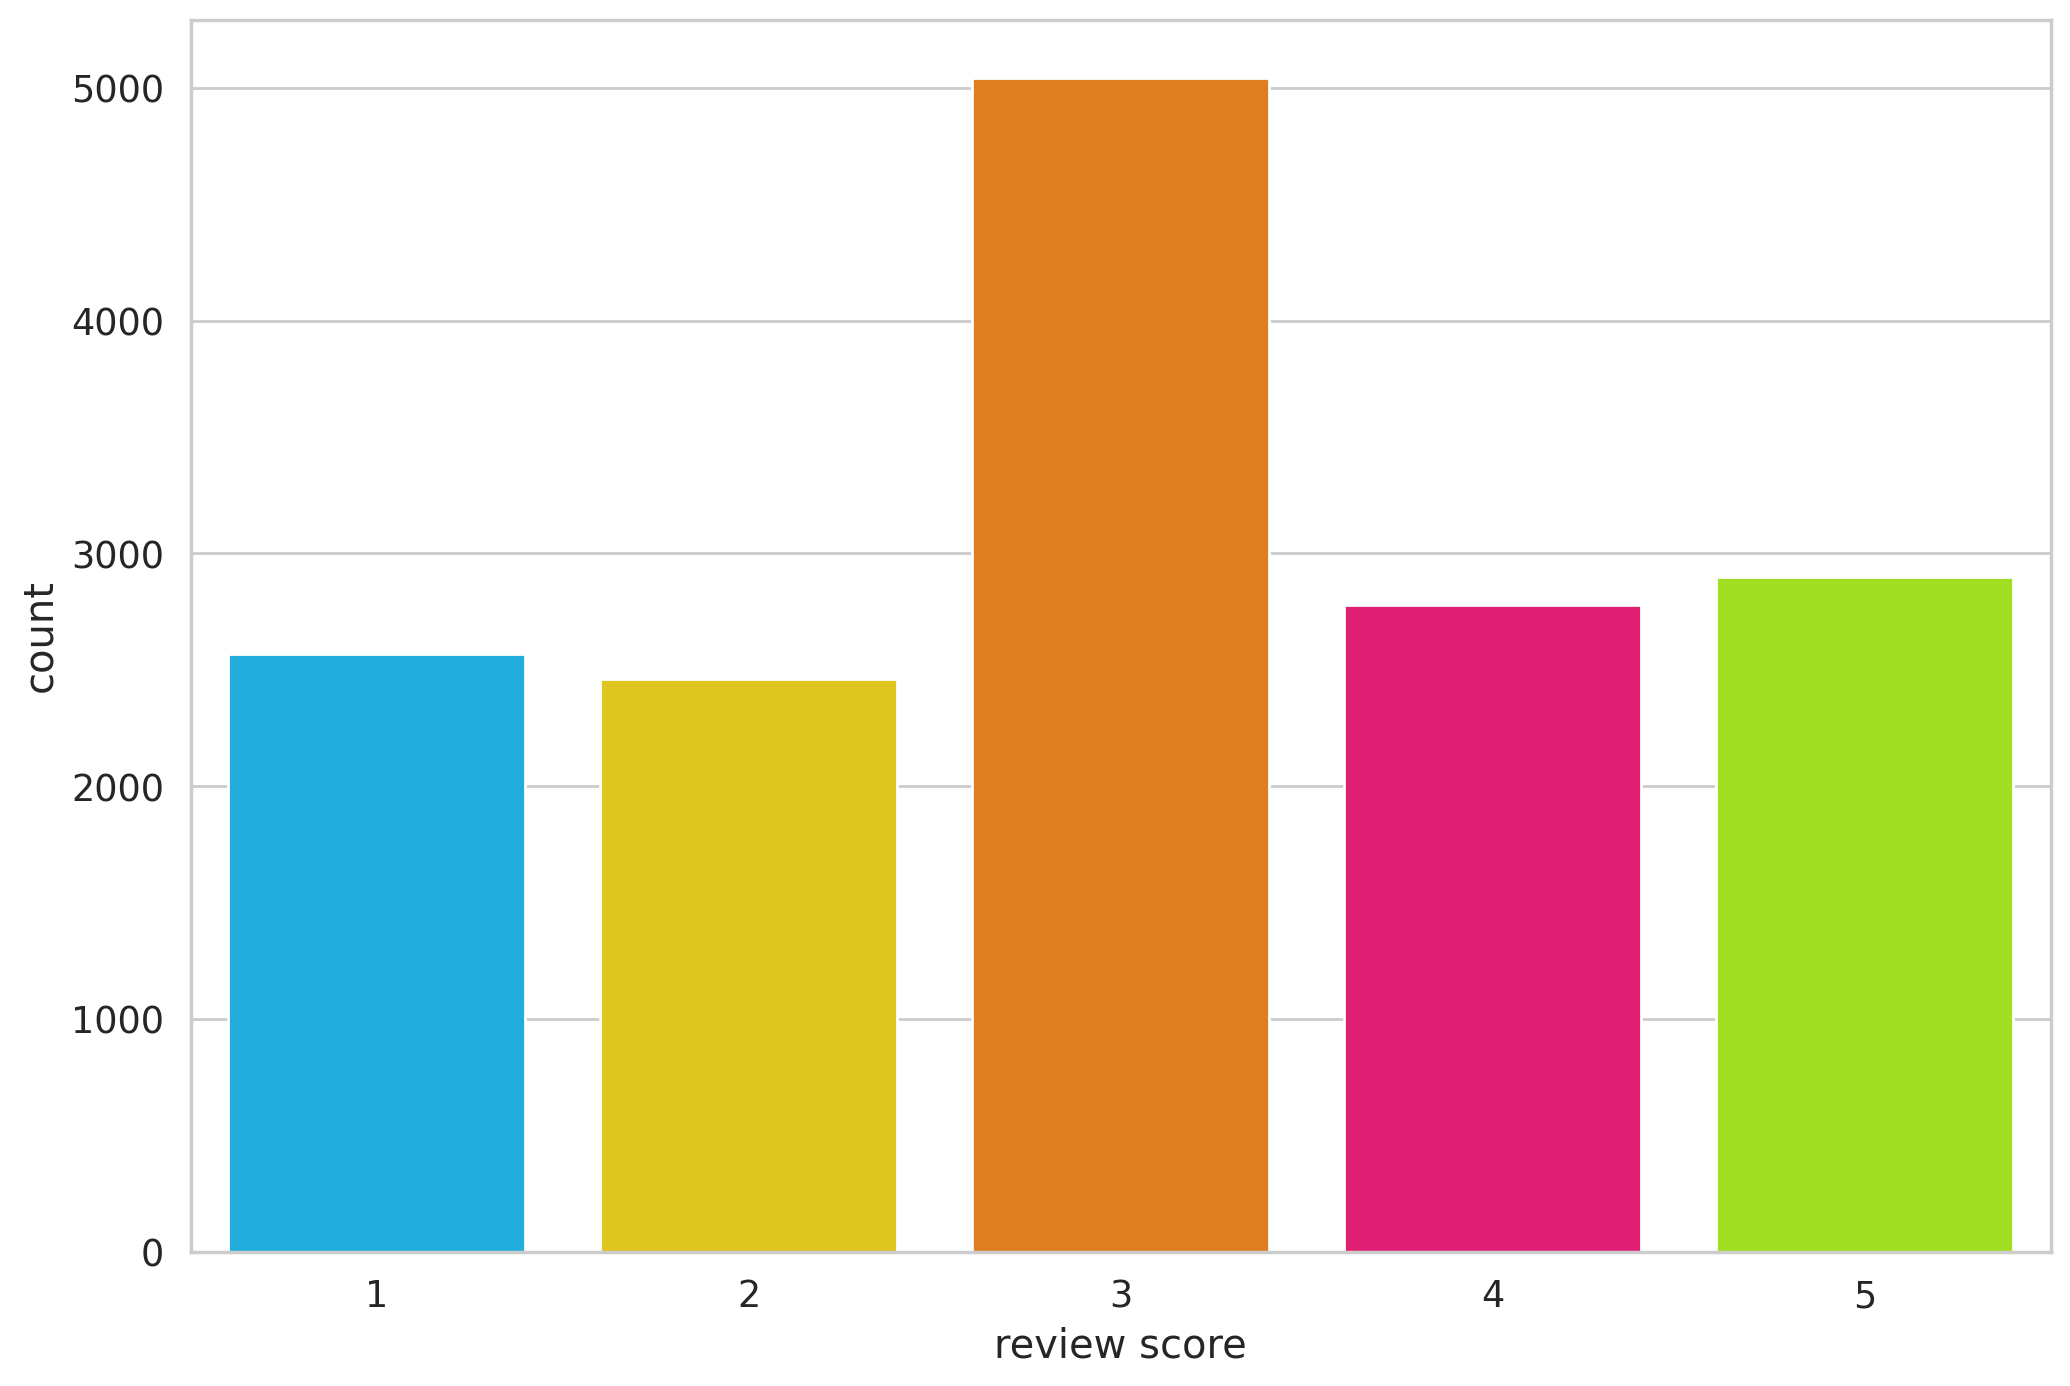

In [ ]:
sns.countplot(df, x="score")
plt.xlabel('review score');

Можно видеть, что данные несбалансированы.
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

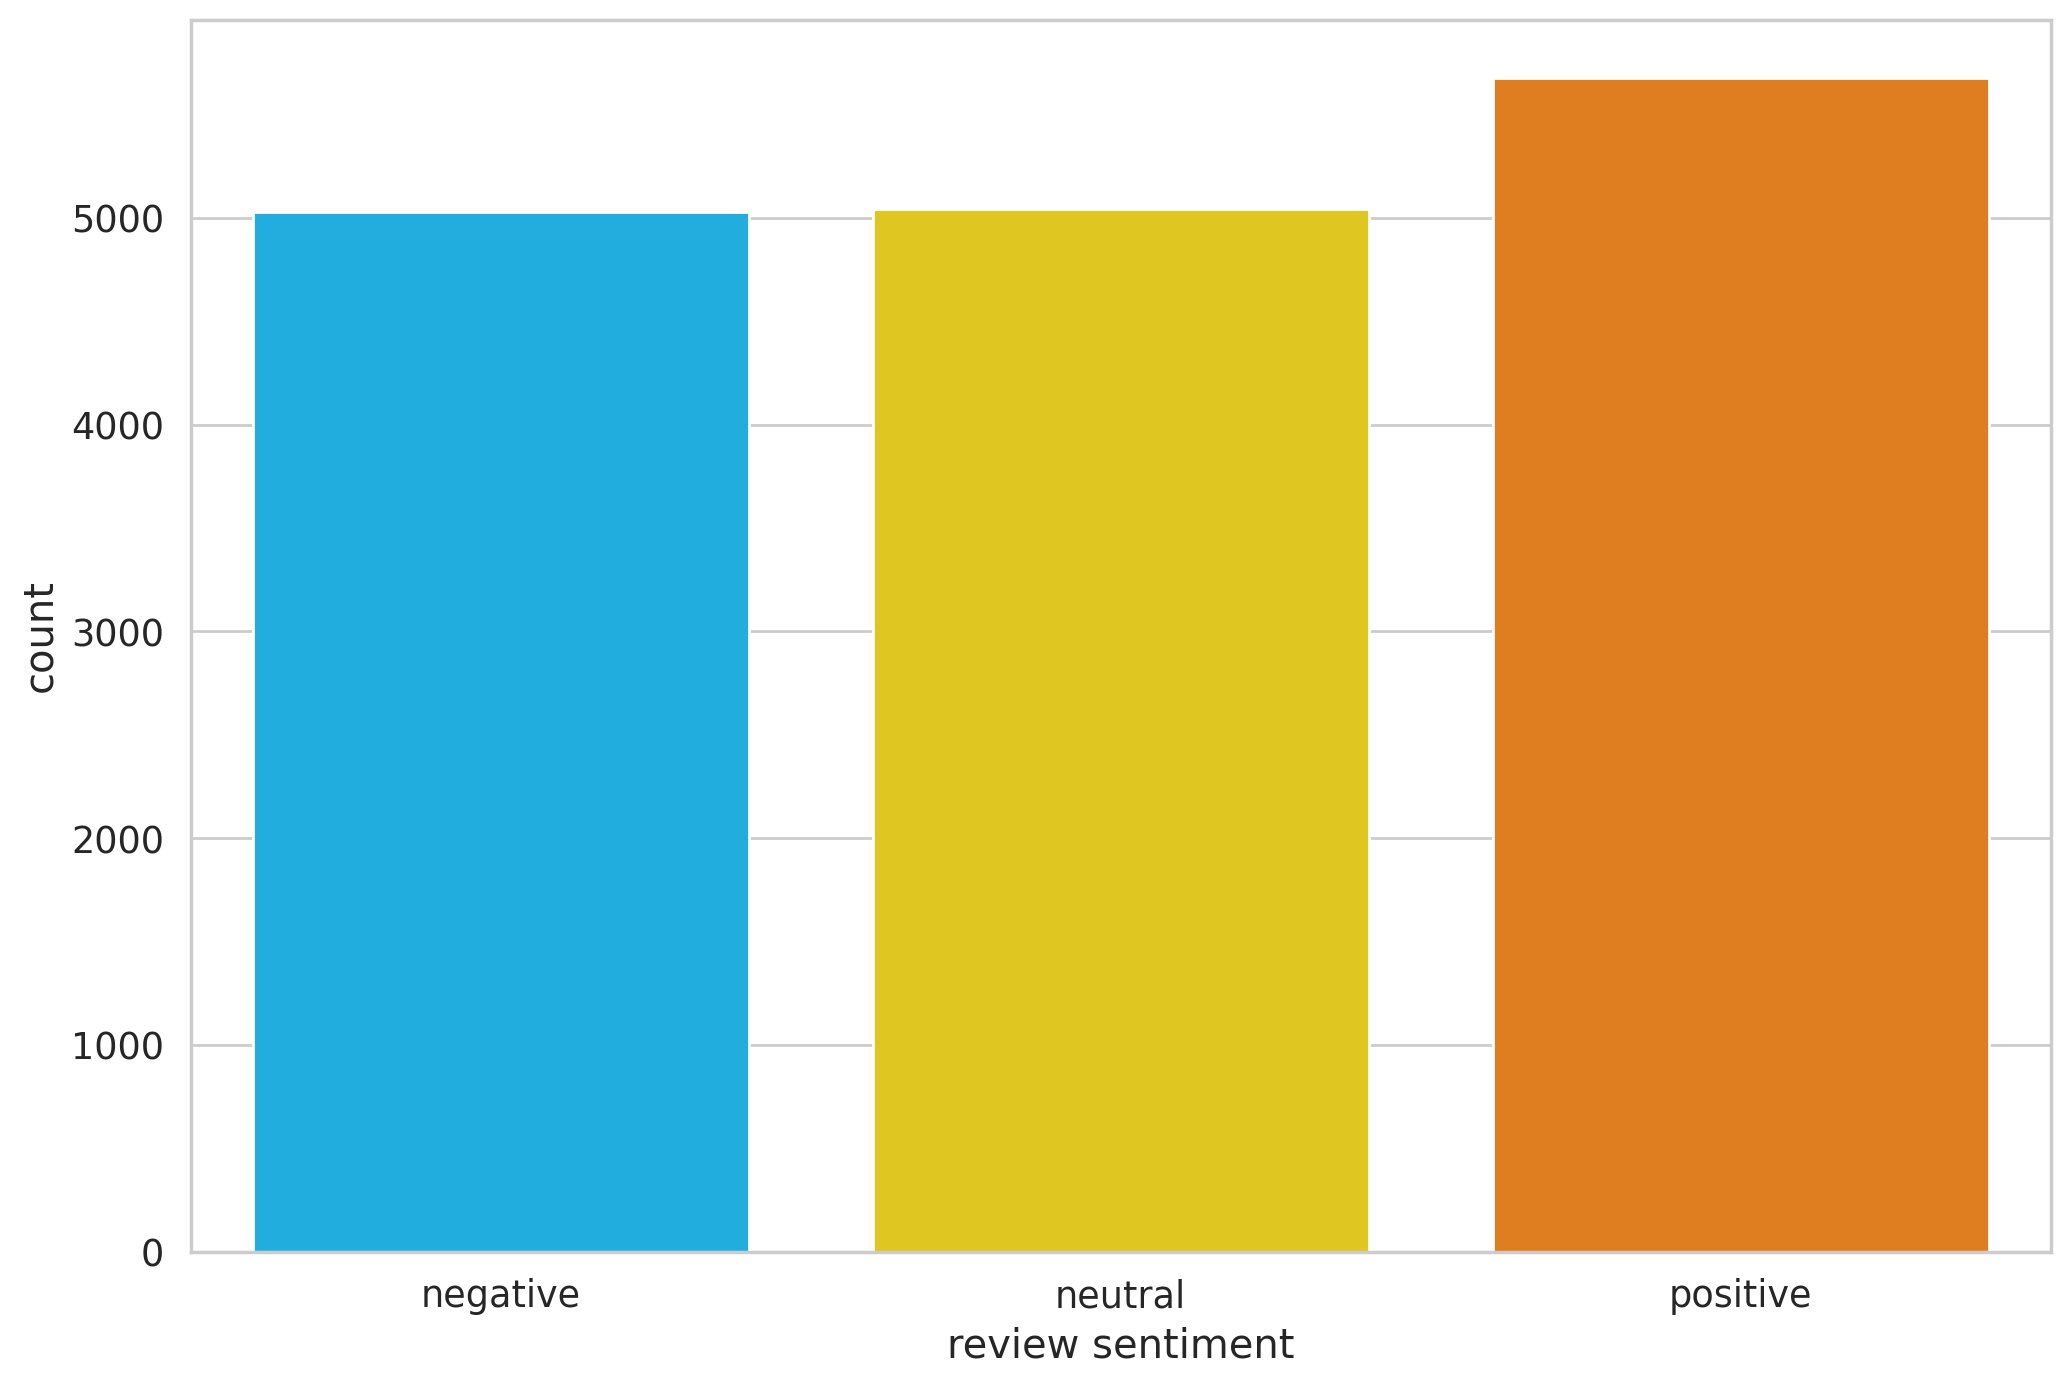

In [ ]:
ax = sns.countplot(df, x="sentiment")
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

## Предобработка данных

Для обучения модели BERT нам нужно обработать исходный текст определенным образом:
* Добавить служебные символы для разделения предложений и классификации
* Привести все последовательности к единой длине (используя padding)
* Создать список (*attention mask*) из 0 и 1, в котором 0 будут соответствовать вспомогательным токенам (padding), а 1 $-$ настоящим.

Будем использовать модели токенизации из библиотеки Hugging Face.

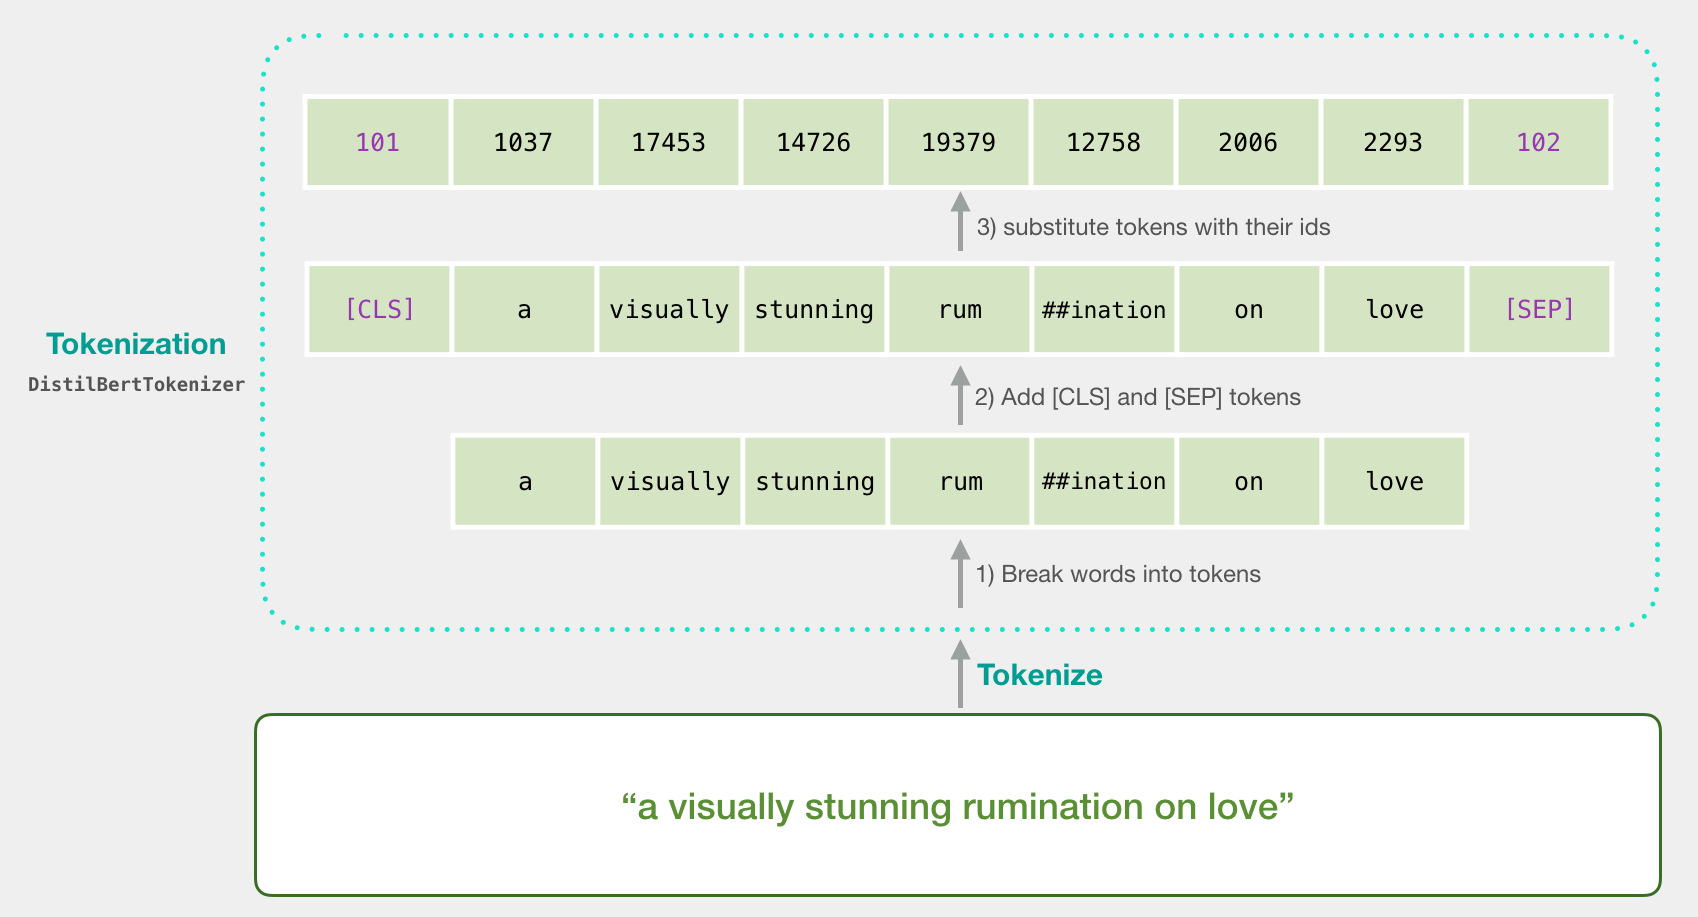

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Посмотрим, как работает модель токенизации для BERT.



In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [ ]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: He started a new book, it was quite readable
   Tokens: ['He', 'started', 'a', 'new', 'book', ',', 'it', 'was', 'quite', 'read', '##able']
Token IDs: [1124, 1408, 170, 1207, 1520, 117, 1122, 1108, 2385, 2373, 1895]



##  Специальные токены

`[SEP]` - метка конца предложения


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

Также существует специальный вспомогательный токен для выравнивания длин последовательностей

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Кроме того, существует специальный токен для неизвестных слов, которые не встречались в обучающей выборке

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

Вся эта предобработка может быть сделана с помощью метода encode_pluse

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1124, 1408,  170, 1207, 1520,  117, 1122, 1108, 2385, 2373, 1895,
         102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Такая же длина будет и у *attention mask*

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


['[CLS]',
 'He',
 'started',
 'a',
 'new',
 'book',
 ',',
 'it',
 'was',
 'quite',
 'read',
 '##able',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Установим максимальную длину последовательности равной 160

In [ ]:
MAX_LEN = 160

Теперь создадим датасет PyTorch, который понадобится в дальнейшем для обучения модели

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, тестовую и валидационную выборки

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

Но на семинаре обрежем данные, чтобы долго не ждать

In [ ]:
df_train = df_train[:1000]
df_val = df_val[:100]
df_test = df_test[:100]

Для обработки данных нам также нужно будет создать итераторы
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=shuffle
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=True)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=False)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=False)

Посмотрим на пример одного батча из нашего итератора train_data_loader



In [ ]:
data = next(iter(train_data_loader))

In [ ]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Классификация сентимента с использованием модели BERT от Hugging Face


В библиотеке Transformers от Hugging Face есть много моделей для разных задач: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) и другие. Все они являются надстройками над базовой моделью BERT.

В данном случае мы будем использовать базовую модель [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и реализуем на её основе свой классификатор текстов по тональности.

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Попробуем использовать эту модель

In [ ]:
outputs = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

Модель возвращает вектора для каждого токена в документе и вектор для токена [CLS], в котором хранится векторное представление всего документа

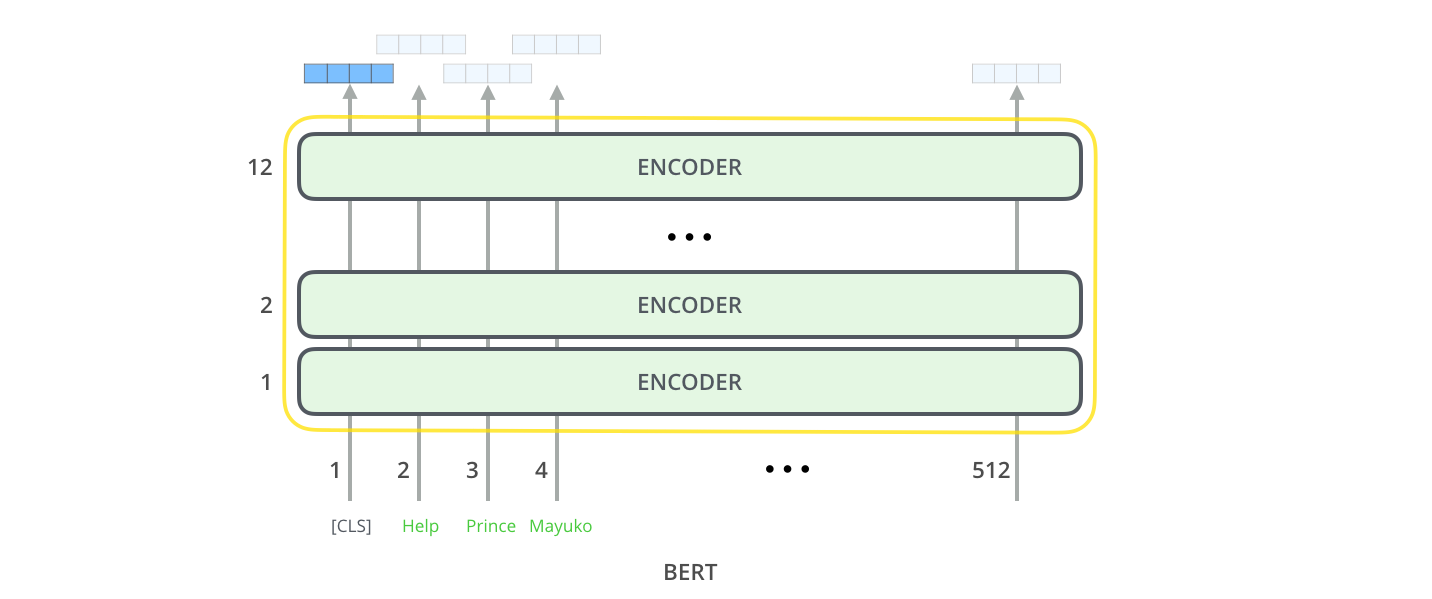

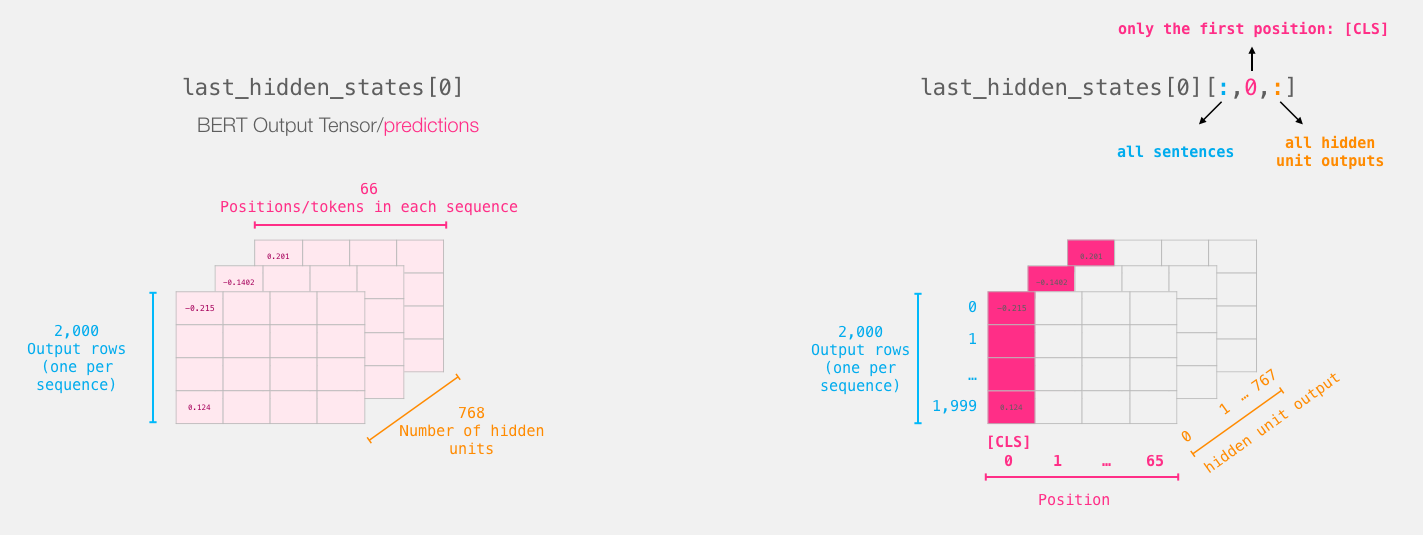

In [ ]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
outputs['pooler_output'].shape

torch.Size([1, 768])

In [ ]:
outputs['last_hidden_state'].shape

torch.Size([1, 32, 768])

#### Классификатор

Будем использовать модель BERT с линейным слоем для классификации.

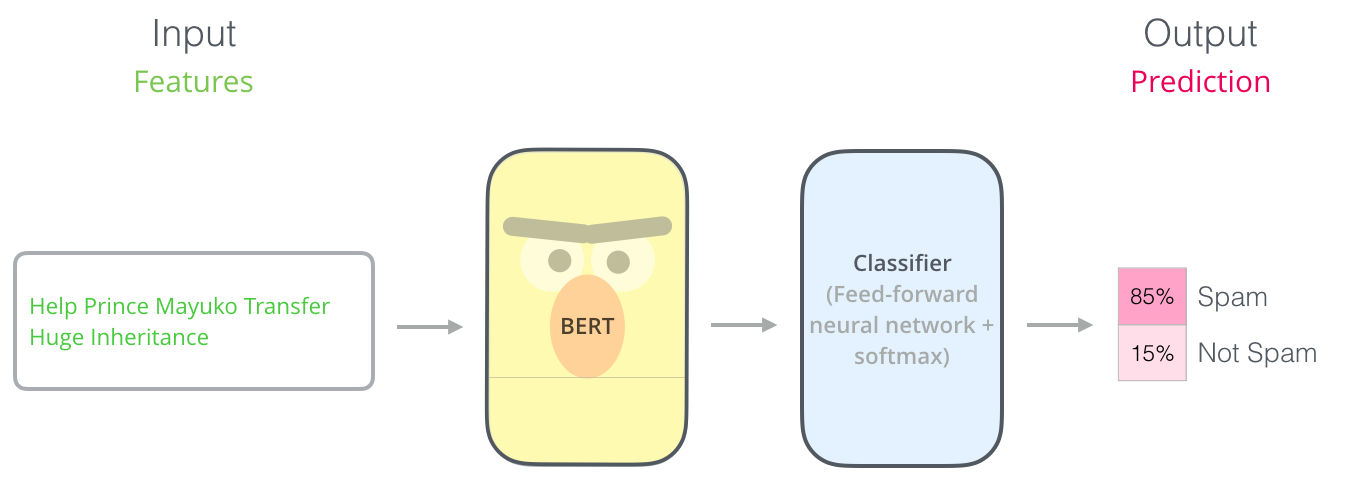

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs["pooler_output"])
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

Перенесем на GPU один из наших батчей (для примера).

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


Чтобы получить вероятности классов, мы применим SoftMax к выходу модели.

In [ ]:
import torch.nn.functional as F

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4331, 0.3715, 0.1954],
        [0.4264, 0.2902, 0.2834],
        [0.3878, 0.3417, 0.2705],
        [0.4475, 0.3311, 0.2214],
        [0.4259, 0.2996, 0.2745],
        [0.3938, 0.3969, 0.2094],
        [0.4213, 0.4358, 0.1429],
        [0.3150, 0.4694, 0.2156],
        [0.4271, 0.3145, 0.2584],
        [0.4096, 0.3521, 0.2383],
        [0.5195, 0.1947, 0.2858],
        [0.4604, 0.4003, 0.1393],
        [0.4133, 0.3685, 0.2182],
        [0.4159, 0.3568, 0.2273],
        [0.4343, 0.2965, 0.2692],
        [0.5178, 0.4182, 0.0640]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Обучение модели

Для дообучения модели будем использовать оптимайзер [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Hugging Face.



Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Реализуем функцию для одной эпохи обучения

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return (correct_predictions.double() / n_examples).item(), np.mean(losses)

Также реализуем функцию для оценки качества модели на данных из data_loader

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return (correct_predictions.double() / n_examples).item(), np.mean(losses)

Используя эти две функции, описанные выше, реализуем процедуру дообучения нашей модели

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.03134670093219491 accuracy 0.989
Val   loss 1.6461659669876099 accuracy 0.67

Epoch 2/10
----------
Train loss 0.03755394091445302 accuracy 0.988
Val   loss 1.6461659669876099 accuracy 0.67

Epoch 3/10
----------
Train loss 0.036144065349141045 accuracy 0.988
Val   loss 1.6461659669876099 accuracy 0.67

Epoch 4/10
----------
Train loss 0.031889559871088415 accuracy 0.988
Val   loss 1.6461659669876099 accuracy 0.67

Epoch 5/10
----------
Train loss 0.03695901948589063 accuracy 0.987
Val   loss 1.6461659669876099 accuracy 0.67

Epoch 6/10
----------
Train loss 0.034774365029223854 accuracy 0.988
Val   loss 1.6461659669876099 accuracy 0.67

Epoch 7/10
----------
Train loss 0.03764600744692698 accuracy 0.987
Val   loss 1.6461659669876099 accuracy 0.67

Epoch 8/10
----------
Train loss 0.03118162880289472 accuracy 0.991
Val   loss 1.6461659669876099 accuracy 0.67

Epoch 9/10
----------
Train loss 0.03426970096142401 accuracy 0.988
Val   loss 1.646165966987


При обучении модели мы сохраняем веса наилучшей модели на основе точности на валидационной выборке.

Обучение модели занимает некоторое время. Теперь мы можем сравнить точность на валидационной и на обучающей выборке.

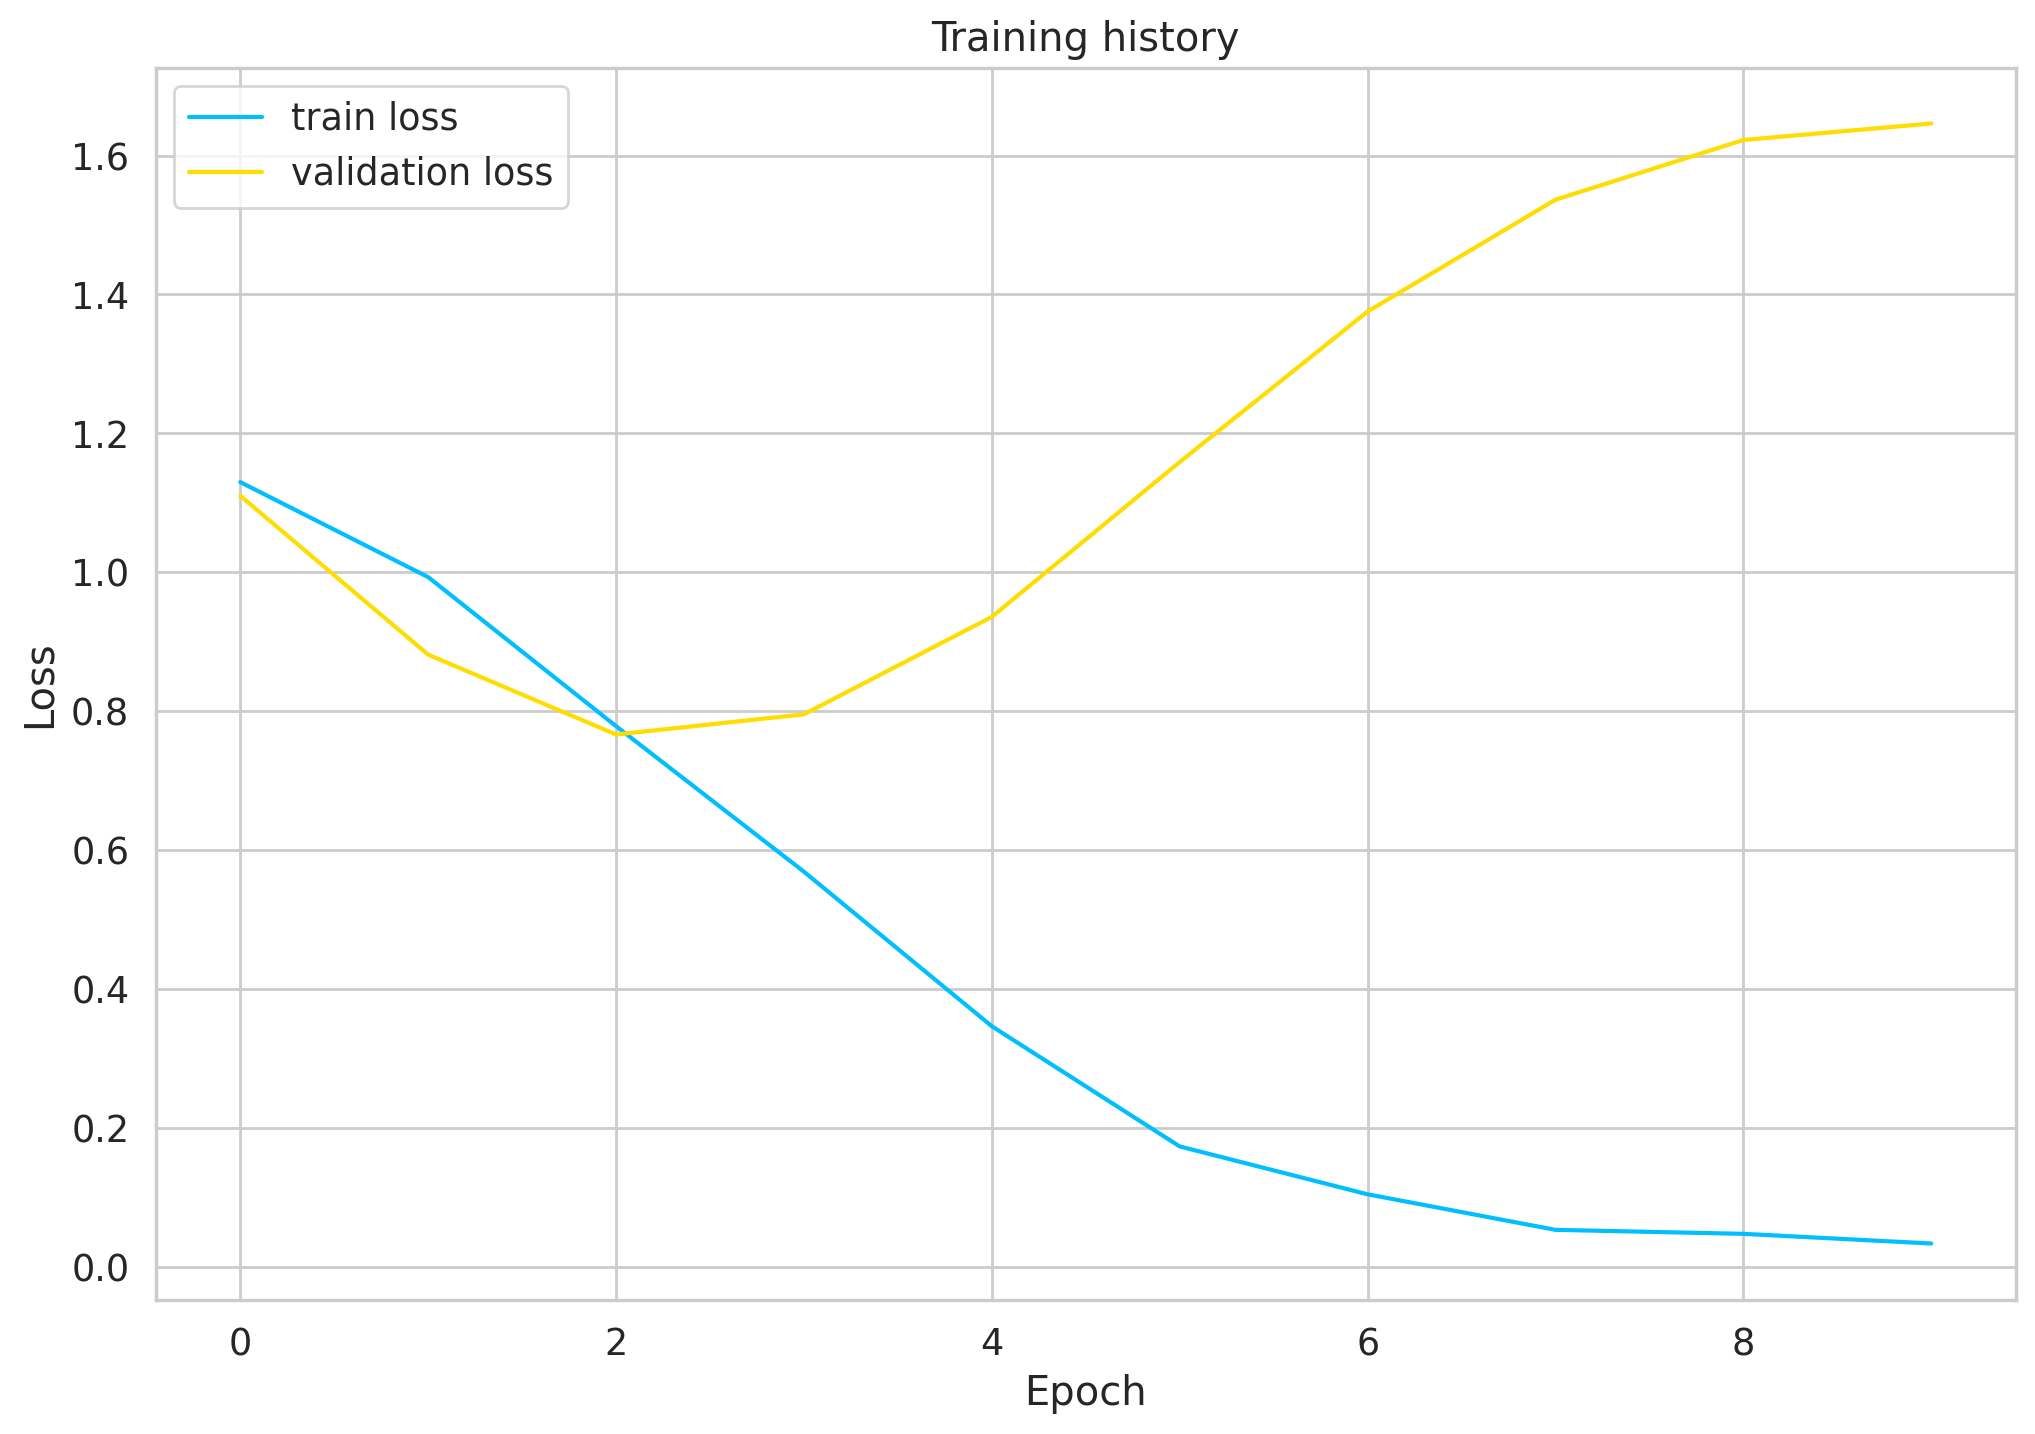

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

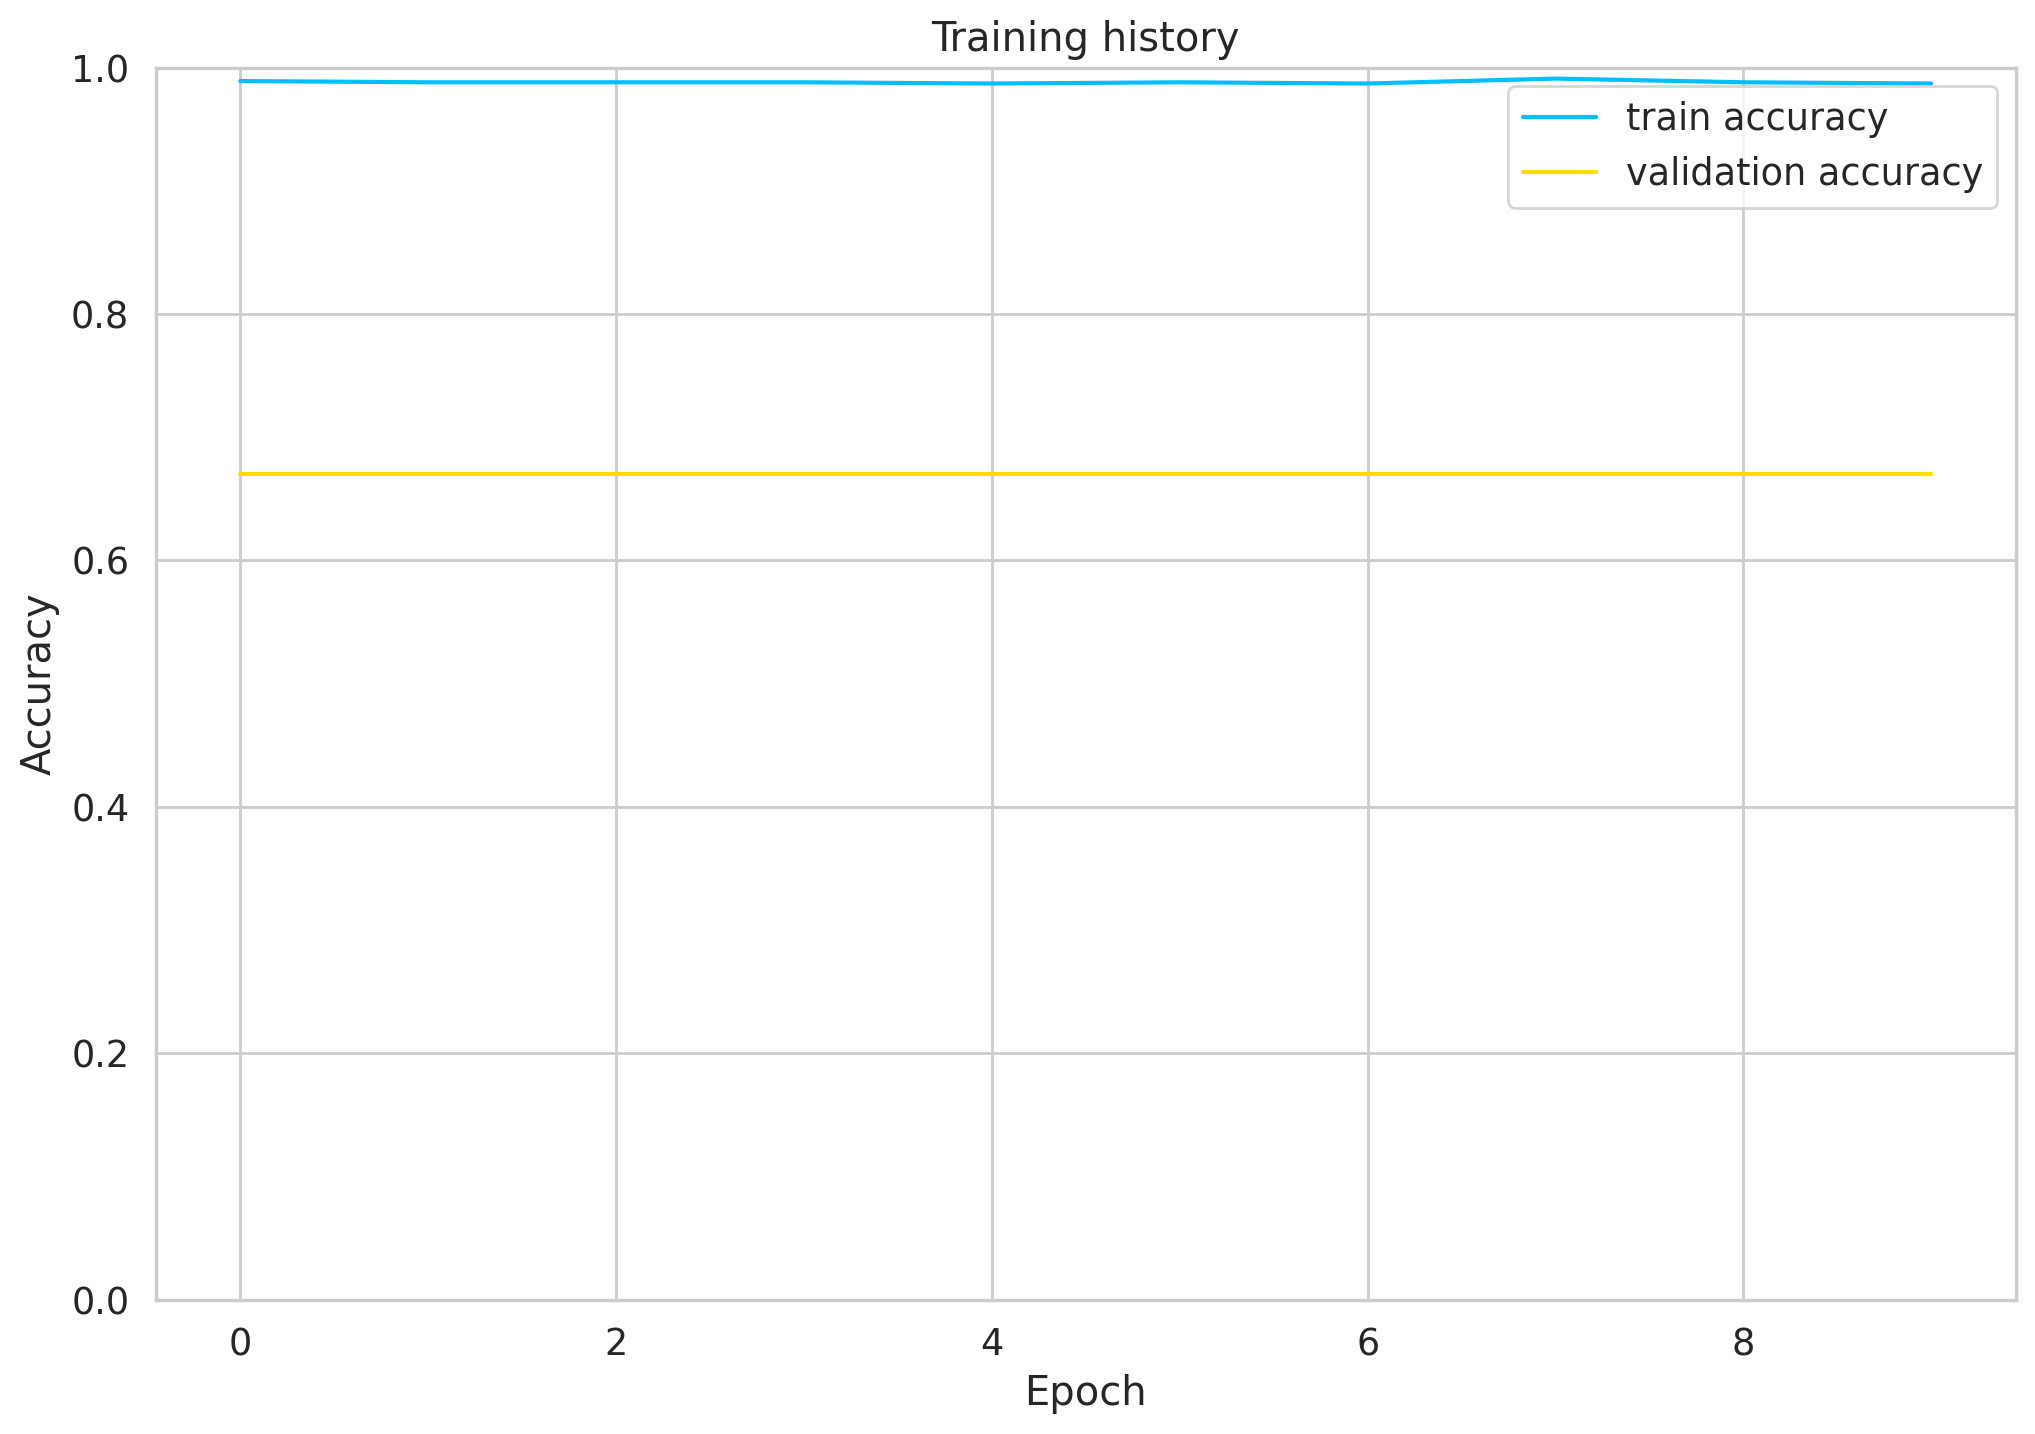

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Из графика видно, что доля правильных ответов модели при обучении приближается к 100% после приблизительно 10 эпох.

In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

## Оценка результатов работы модели

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc

0.71

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.61      0.42      0.50        26
     neutral       0.60      0.75      0.67        36
    positive       0.89      0.87      0.88        38

    accuracy                           0.71       100
   macro avg       0.70      0.68      0.68       100
weighted avg       0.71      0.71      0.70       100



Из данного отчета видно, что сложнее всего классифицировать негативные отзывы.

Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

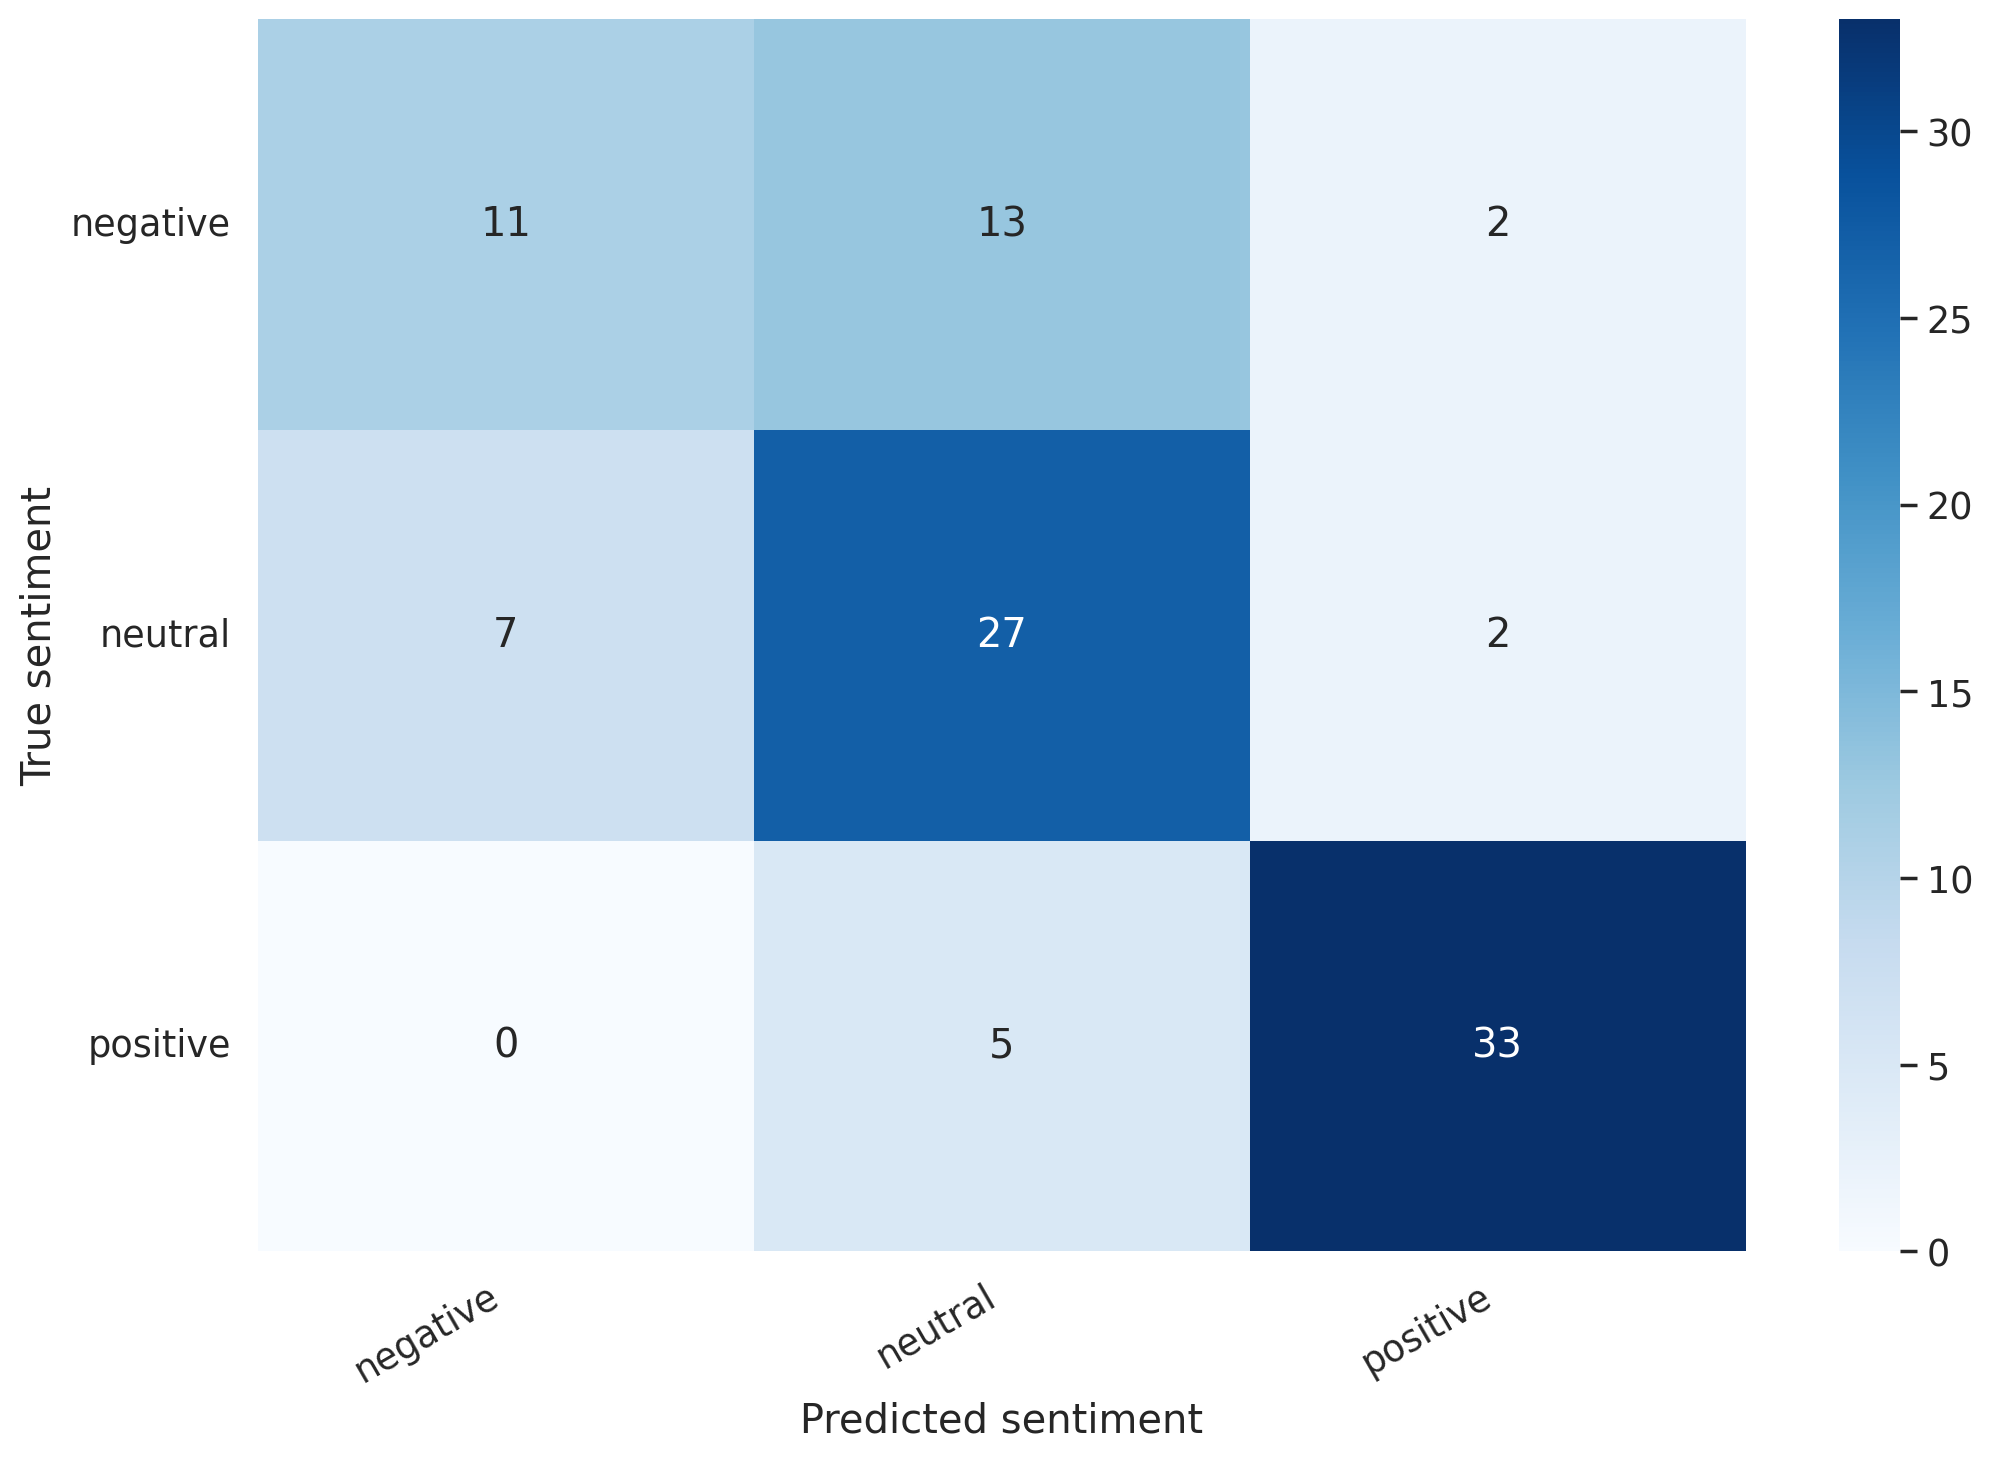

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать негативные отзывы.

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
pred_df

,class_names,values
0,negative,0.000236
1,neutral,0.001338
2,positive,0.998426


In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True sentiment: neutral


## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive


## Домашнее задание

1. Обучите модель на всех данных и сделайте перебор гиперпараметров, чтобы добиться лучшего качества.
2. Попробуйте использовать другую предобученную модель BERT (например, bert-base-uncased) и сравните качество классификации. Модели Transformers: https://huggingface.co/transformers/pretrained_models.html (Возможно, надо будет изменить предобработку текста)
3. Попробуйте использовать [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification). Изучите документацию, чтобы понять, как инициализировать и использовать модель.
3. *Попробуйте добавить аугментацию для восстановления баланса классов и обучить классификатор, сравните результаты с базовой версией модели. Для аугментации можно попробовать использовать библиотеку [nlpaug](https://github.com/makcedward/nlpaug).

Пример аугментации:

In [ ]:
!pip install torch>=1.6.0 transformers>=3.0.2
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.3 MB/s eta 0:00:00


In [ ]:
import nlpaug.augmenter.word as naw

aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action='substitute')


In [ ]:
augmented_text = aug.augment('tell me the story about your life')
augmented_text[0]

'tell them the secret about the life'

Напоминаю, что отправлять задание на проверку и задавать вопросы вы можете мне в телеграме @Julia_Korot до следующей пары 18.10.2023.

## Итоги

На этом занятии мы научились использовать модель BERT для классификации текстов по тональности.

Мы научились обрабатывать исходные тексты так, чтобы их можно было использовать для обучения модели BERT.

Мы построили собственный классификатор с помощью библиотеки Huggig Face и дообучили его на данных отзывов на приложения Google Play.